# &#x1F4D1; &nbsp; TensorFlow  Cookbook 
## 0. Code Library and Links


In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron');
body {background-color: gainsboro;} 
a {color: darkgreen; font-family: 'Orbitron';} 
h1 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;} 
h2, h3 {color: darkslategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
</style>

In [2]:
import numpy as np 
import pandas as pd
from scipy import misc
from collections import namedtuple

import cv2
from PIL import ImageFile
from tqdm import tqdm
from keras.preprocessing import image as keras_image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.image as plt_image
from matplotlib import cm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [3]:
import tensorflow as tf
import tflearn

In [4]:
import tflearn.datasets.mnist as mnist
from tflearn.data_utils import build_hdf5_image_dataset

## 1. Data Sets

In [5]:
# MNIST
X_train, y_train, X_test, y_test = mnist.load_data(one_hot=True)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [6]:
[X_train.shape, y_train.shape, X_test.shape, y_test.shape]

[(55000, 784), (55000, 10), (10000, 784), (10000, 10)]

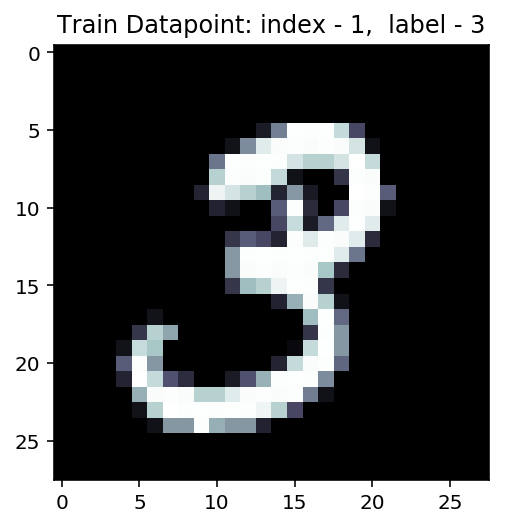

In [7]:
def display_digit(index):
    label = y_train[index].argmax(axis=0)
    image = X_train[index].reshape(28,28)
    plt.title('Train Datapoint: index - %d,  label - %d' % (index, label))
    plt.imshow(image, cmap=cm.bone)

display_digit(1)

In [8]:
# Anna Karenina Text
with open('anna.txt', 'r') as f:
    text=f.read()
vocabulary = set(text)
int_to_vocab = dict(enumerate(vocabulary))
vocab_to_int = dict((v,k) for k,v in int_to_vocab.items())
characters = np.array([vocab_to_int[c] for c in text], dtype=np.int32)

In [9]:
text[:109]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverything was in '

In [10]:
characters[:109]

array([62, 12, 33, 82, 60, 14, 44, 47, 29, 58, 58, 58,  7, 33, 82, 82,  8,
       47, 36, 33, 64, 24,  9, 24, 14, 48, 47, 33, 44, 14, 47, 33,  9,  9,
       47, 33,  9, 24, 35, 14, 54, 47, 14, 70, 14, 44,  8, 47, 25, 46, 12,
       33, 82, 82,  8, 47, 36, 33, 64, 24,  9,  8, 47, 24, 48, 47, 25, 46,
       12, 33, 82, 82,  8, 47, 24, 46, 47, 24, 60, 48, 47, 74, 57, 46, 58,
       57, 33,  8, 72, 58, 58, 71, 70, 14, 44,  8, 60, 12, 24, 46, 10, 47,
       57, 33, 48, 47, 24, 46, 47], dtype=int32)

In [11]:
batch_size, num_steps, split_fraction = 100, 100, 0.9

slice_size = batch_size * num_steps
n_batches = int(len(characters) / slice_size)
# targets = features, shifted one character over
X2 = characters[: n_batches*slice_size]
y2 = characters[1: n_batches*slice_size + 1]

X2 = np.stack(np.split(X2, batch_size))
y2 = np.stack(np.split(y2, batch_size))

split_id = int(n_batches*split_fraction)
X_train2, y_train2= X2[:, :split_id*num_steps], y2[:, :split_id*num_steps]
X_test2, y_test2 = X2[:, split_id*num_steps:], y2[:, split_id*num_steps:]    

In [12]:
[X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape]

[(100, 17800), (100, 17800), (100, 2000), (100, 2000)]

In [13]:
# 128x128 color images
flowers = pd.read_csv("flower_images/flower_labels.csv")
flower_files = flowers['file']
flower_targets = flowers['label'].as_matrix()

def path_to_tensor(img_path):
    img = keras_image.load_img("flower_images/"+img_path, target_size=(128, 128))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True                 
flower_tensors = paths_to_tensor(flower_files);

100%|██████████| 210/210 [00:06<00:00, 49.33it/s]


Label:  7


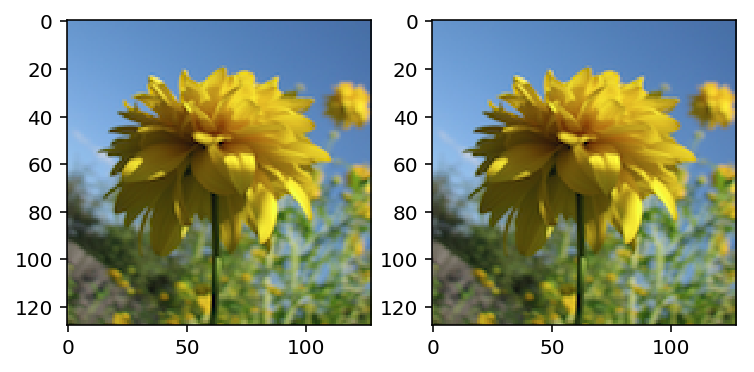

In [14]:
# rgb_image = tf.image.decode_png("flower_images/0023.png")
# rgb_image_float = tf.image.convert_image_dtype(rgb_image, tf.float32)

img_scipy = misc.imread('flower_images/0023.png') 

image_tf = tf.Variable(img_scipy)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
img_tf = sess.run(image_tf)

print('Label: ', flower_targets[22])
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img_scipy)
fig.add_subplot(1,2,2)
plt.imshow(img_tf);

In [15]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(flower_tensors, flower_targets, 
                                                        test_size = 0.1, random_state = 1)
X_train3 = X_train3.astype('float32')/255
X_test3 = X_test3.astype('float32')/255

c_y_train3 = to_categorical(y_train3, 10)
c_y_test3 = to_categorical(y_test3, 10)
[X_train3.shape, c_y_train3.shape, X_test3.shape, c_y_test3.shape]

[(189, 128, 128, 3), (189, 10), (21, 128, 128, 3), (21, 10)]

## 2. Basics

In a **dataflow graph**, the nodes represent units of computation, and the edges represent the data consumed or produced by a computation.

A `tf.Graph` contains two relevant kinds of information:

 * Graph structure, i.e. the nodes and edges of the graph, indicating how individual operations are composed together, but not prescribing how they should be used.
 * Graph collections for storing the metadata.

In [16]:
# Feed data into graphs through placeholders
x = tf.placeholder("float32", [None, None])
y = (x-0.011) ** 2

with tf.Session() as session:
    result = session.run(y, feed_dict={x: [[0.19, 0.23, 0.37], [0.43, 0.55, 0.61]]})
    print(result)

[[ 0.032041    0.047961    0.12888099]
 [ 0.175561    0.29052103  0.35880104]]


Epoch: 0050 cost= 0.107380994 W= 0.347181 b= 0.0994277
Epoch: 0100 cost= 0.103865460 W= 0.341377 b= 0.141181
Epoch: 0150 cost= 0.100756116 W= 0.335918 b= 0.180451
Epoch: 0200 cost= 0.098006099 W= 0.330784 b= 0.217386
Epoch: 0250 cost= 0.095573872 W= 0.325955 b= 0.252124
Epoch: 0300 cost= 0.093422793 W= 0.321414 b= 0.284797
Epoch: 0350 cost= 0.091520317 W= 0.317142 b= 0.315526
Epoch: 0400 cost= 0.089837819 W= 0.313125 b= 0.344426
Epoch: 0450 cost= 0.088349774 W= 0.309346 b= 0.371609
Epoch: 0500 cost= 0.087033808 W= 0.305793 b= 0.397175
Epoch: 0550 cost= 0.085870035 W= 0.30245 b= 0.42122
Epoch: 0600 cost= 0.084840864 W= 0.299306 b= 0.443835
Epoch: 0650 cost= 0.083930708 W= 0.29635 b= 0.465105
Epoch: 0700 cost= 0.083125837 W= 0.293569 b= 0.48511
Epoch: 0750 cost= 0.082414113 W= 0.290954 b= 0.503925
Epoch: 0800 cost= 0.081784755 W= 0.288494 b= 0.521621
Epoch: 0850 cost= 0.081228226 W= 0.28618 b= 0.538265
Epoch: 0900 cost= 0.080736086 W= 0.284004 b= 0.553919
Epoch: 0950 cost= 0.080300935 W=

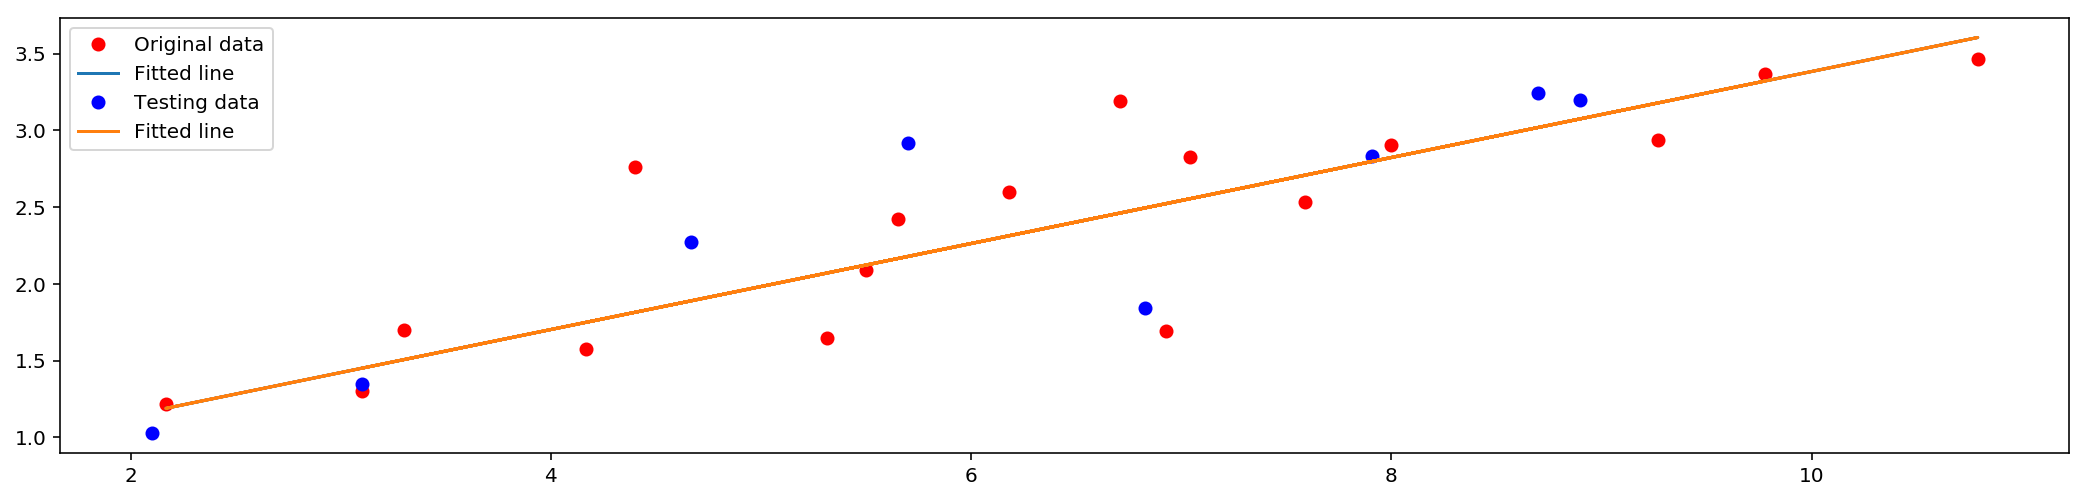

In [40]:
# Linear Regression; TensorFlow
tf.reset_default_graph()

learning_rate = 0.01
training_epochs = 1000
display_step = 50

# Training Data
train_X = np.asarray([3.3,4.4,5.5,6.71,6.93,4.168,9.779,6.182,7.59,2.167,
                         7.042,10.791,5.313,7.997,5.654,9.27,3.1])
train_Y = np.asarray([1.7,2.76,2.09,3.19,1.694,1.573,3.366,2.596,2.53,1.221,
                         2.827,3.465,1.65,2.904,2.42,2.94,1.3])
n_samples = train_X.shape[0]

# tf Graph Input
X = tf.placeholder("float")
Y = tf.placeholder("float")

# Set model weights
W = tf.Variable(np.random.randn(), name="weight")
b = tf.Variable(np.random.randn(), name="bias")

# Construct a linear model
pred = tf.add(tf.multiply(X, W), b)

# Mean squared error
cost = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*n_samples)
# Gradient descent
#  Note, minimize() knows to modify W and b because Variable objects are trainable=True by default
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Fit all training data
    for epoch in range(training_epochs):
        for (x, y) in zip(train_X, train_Y):
            sess.run(optimizer, feed_dict={X: x, Y: y})

        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c = sess.run(cost, feed_dict={X: train_X, Y:train_Y})
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), \
                "W=", sess.run(W), "b=", sess.run(b))

    print("Optimization Finished!")
    training_cost = sess.run(cost, feed_dict={X: train_X, Y: train_Y})
    print("Training cost=", training_cost, "W=", sess.run(W), "b=", sess.run(b), '\n')

    # Graphic display
    plt.figure(figsize=(18,4))
    plt.plot(train_X, train_Y, 'ro', label='Original data')
    plt.plot(train_X, sess.run(W) * train_X + sess.run(b), label='Fitted line')
    plt.legend()
    
    # Testing example, as requested (Issue #2)
    test_X = np.asarray([6.83, 4.668, 8.9, 7.91, 5.7, 8.7, 3.1, 2.1])
    test_Y = np.asarray([1.84, 2.273, 3.2, 2.831, 2.92, 3.24, 1.35, 1.03])

    print("Testing... (Mean square loss Comparison)")
    testing_cost = sess.run(
        tf.reduce_sum(tf.pow(pred - Y, 2)) / (2 * test_X.shape[0]),
        feed_dict={X: test_X, Y: test_Y})  # same function as cost above
    print("Testing cost=", testing_cost)
    print("Absolute mean square loss difference:", abs(
        training_cost - testing_cost))

    plt.plot(test_X, test_Y, 'bo', label='Testing data')
    plt.plot(train_X, sess.run(W) * train_X + sess.run(b), label='Fitted line')
    plt.legend()

In [41]:
# Linear Regression; TFLearn
dual_currency_basket_210917 = [63.7716, 63.7873, 63.8250, 63.9114, 63.8960, 63.6317, 63.8868, 63.8921, 
                               63.5300, 62.9803, 62.7065, 62.7679, 62.3237, 62.1372, 62.2597, 62.3352, 
                               62.3422, 62.8113, 62.6866, 62.5045, 62.6314, 63.3099, 63.3658]


gold_210917 = [2448.2700, 2439.3300, 2445.6800, 2444.9900, 2447.5000, 2419.3500, 2490.4400, 2474.7200, 
               2457.8800, 2460.8400, 2479.3200, 2475.8400, 2470.5400, 2462.5800, 2475.5000, 2460.6700, 
               2441.8000, 2470.0800, 2457.3000, 2450.9100, 2435.1400, 2444.1000, 2457.4000]

In [42]:
tf.reset_default_graph()
lr_inputs = tflearn.input_data(shape=[None])
lr = tflearn.single_unit(lr_inputs)
                    
linear_regression = tflearn.regression(lr, optimizer='sgd', loss='mean_square',
                                       metric='R2', learning_rate=0.01)
dnn_lr = tflearn.DNN(linear_regression)
dnn_lr.fit(dual_currency_basket_210917, gold_210917, 
           n_epoch=1000, show_metric=True, snapshot_epoch=False)

Training Step: 1000  | total loss: 1047.86169 | time: 0.006s
| SGD | epoch: 1000 | loss: 1047.86169 - R2: 0.9995 -- iter: 23/23


In [43]:
print("Regression result: \n")
print("gold_210917 = " + str(dnn_lr.get_weights(lr.W)) +
      " * dual_currency_basket_210917 + " + str(dnn_lr.get_weights(lr.b)))

Regression result: 

gold_210917 = [ 38.92863464] * dual_currency_basket_210917 + [ 1.33637106]


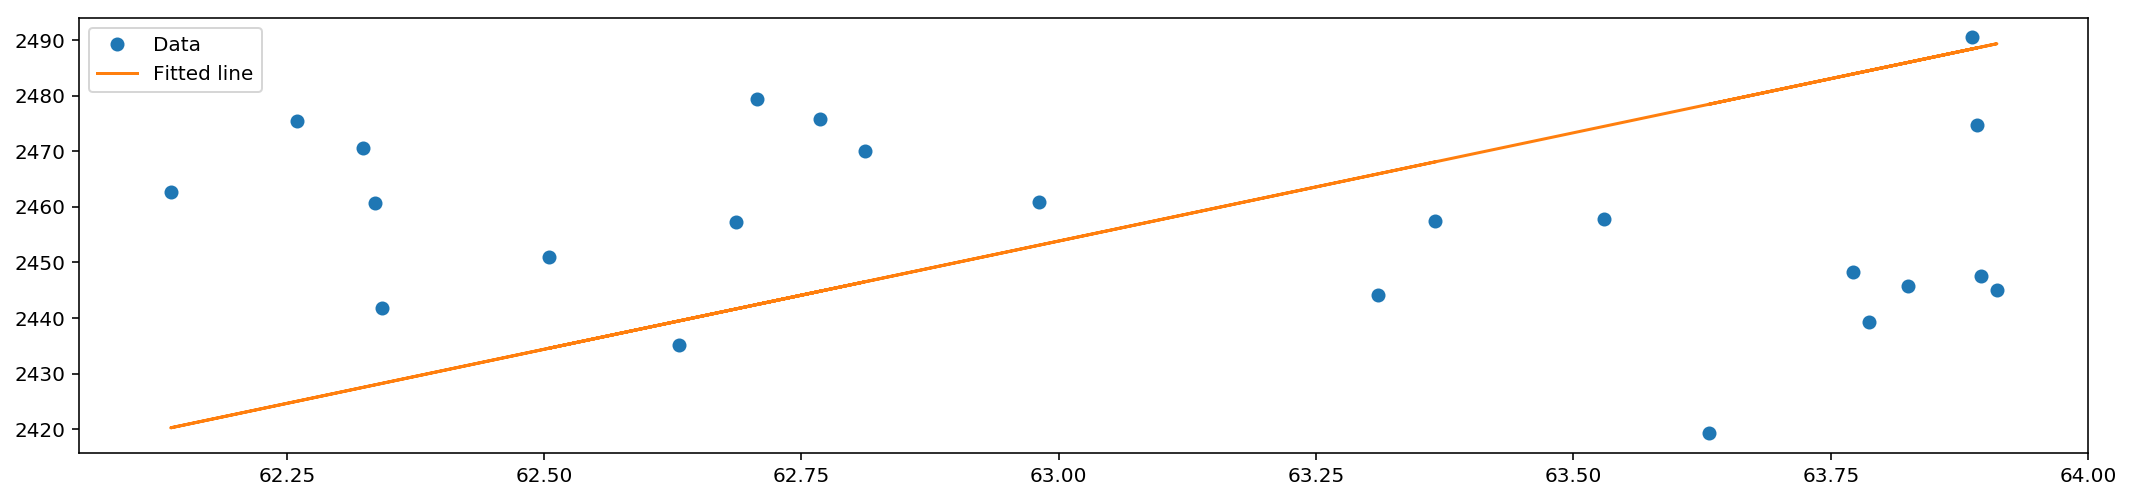

In [44]:
plt.figure(figsize=(18,4))
plt.plot(dual_currency_basket_210917, gold_210917, 'o', label = 'Data');
plt.plot(dual_currency_basket_210917, 
         dnn_lr.get_weights(lr.W) * dual_currency_basket_210917 + dnn_lr.get_weights(lr.b), 
         label='Fitted line')
plt.legend();

In [45]:
print("Test prediction for dual currency basket = [62.7081  63.4157  63.9709]: \n")
print(dnn_lr.predict([62.7081, 63.4157, 63.9709]))

Test prediction for dual currency basket = [62.7081  63.4157  63.9709]: 

[ 2442.47705078  2470.02294922  2491.63623047]


An **embedding** is a mapping from discrete objects, such as words, to vectors of real numbers.

The Embedding Projector provides three ways to reduce the dimensionality of a data set (`t-SNE`, `PCA`, `Custom`).

## 3. Neural Networks; TensorFlow
### MLP

### CNN

### RNN 

## 4. Neural Networks; Tflearn
### MLP

In [67]:
def mlp_mc_model():
    tf.reset_default_graph()
    
    nn = tflearn.input_data([None, 784])
    
    nn = tflearn.fully_connected(nn, 784, activation='ReLU')    
    nn = tflearn.fully_connected(nn, 392, activation='ReLU')
    
    nn = tflearn.fully_connected(nn, 10, activation='Softmax')
    
    acc = tflearn.metrics.Accuracy()
    nn = tflearn.regression(nn, optimizer='adam', learning_rate=0.01, 
                            loss='categorical_crossentropy', metric=acc)
    model = tflearn.DNN(nn)
    return model

mlp_mc_model = mlp_mc_model()

In [68]:
mlp_mc_model.fit(X_train, y_train, validation_set=0.1, show_metric=True, batch_size=128, n_epoch=30)

Training Step: 11609  | total loss: 1.64038 | time: 12.453s
| Adam | epoch: 030 | loss: 1.64038 - acc: 0.9167 -- iter: 49408/49500
Training Step: 11610  | total loss: 1.47882 | time: 13.489s
| Adam | epoch: 030 | loss: 1.47882 - acc: 0.9242 | val_loss: 0.20089 - val_acc: 0.9687 -- iter: 49500/49500
--


In [69]:
y_test_mlp = np.array(mlp_model.predict(X_test)).argmax(axis=1)
y_test_num = y_test.argmax(axis=1)

test_accuracy_mlp = np.mean(y_test_mlp == y_test_num, axis=0)

print("Test Accuracy: {} %".format(test_accuracy_mlp*100))

Test Accuracy: 95.53 %


### CNN

### RNN